# Profiling

El primer paso antes de optimizar es identificar los sectores críticos o "cuellos de botella" de nuestro programa. A esto lo llamamos hacer un *profiling* de código

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## ¿Qué es *profiling*?

Se refiere a medir los 

1. Tiempos de ejecución (total, por función, por linea)
1. Uso de recursos (memoria, cpu, disco)

de una rutina con el fin de encontrar aquellas secciones más lentas e ineficientes (sectores críticos)

> Luego de identificarlas podemos reescribirlas u optimizarlas

A continuación veremos como hacer *profiling* de nuestro código en Python usando el ambiente *Jupyter* y las magias de *IPython*

**Ejemplo:** Set de Julia

A modo de ejemplo haremos *profiling* de un script de Python que calcula el famoso fractal conocido como el Set de Julia

El [set de Julia](https://en.wikipedia.org/wiki/Julia_set) es un fractal asociado a la función

$$
f(z) = z^2 + c,
$$
donde $c \in \mathbb{C}$

El script [fractal.py](./fractal.py) tiene una implementación del set de Julia usando Python puro, es decir sin usar librerias

In [2]:
from IPython.display import Code
Code(filename="src/fractal.py")

def evaluate_z(zi, zr, maxiters=50, cr=-0.835, ci=-0.2321):
    nit = 0
    zi2 = zi**2
    zr2 = zr**2
    while zi2 + zr2 <= 4. and nit < maxiters:
        zi = 2*zr*zi + ci
        zr = zr2 - zi2 + cr
        zr2 = zr**2
        zi2 = zi**2 
        nit +=1
    return nit
    
def make_fractal(N, maxiters=50):
    image = []
    for i in range(N):
        row = []
        for j in range(2*N):
            zi = -1.0 + i*2/N
            zr = -2.0 + j*2/N
            row.append(evaluate_z(zi, zr, maxiters))
        image.append(row)
    return image

Si ejecutamos la función `make_fractal` con una resolución de 500 pixeles y 50 iteraciones el resultado es

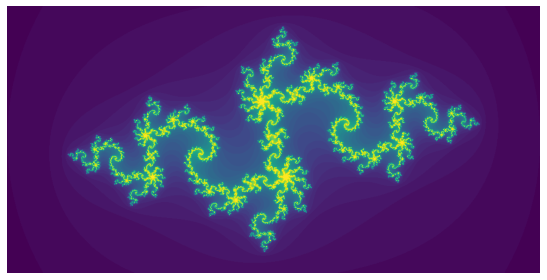

In [3]:
from src.fractal import make_fractal, evaluate_z

fractal_image = make_fractal(N=500, maxiters=50)

fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)
ax.imshow(fractal_image, aspect='equal', origin='lower')
ax.axis('off');

## Midiendo tiempo de ejecución

### Tiempo total usando magias de IPython

A continuación revisaremos algunas magias de IPython que nos permiten medir el tiempo de ejecución de un script, función o expresión de Python de forma simple y conveniente

La primera es `%time` que se usa anteponiendose a una función

```python
%time mi_resultado = mi_funcion(mis_argumentos)
```

Esto retorna algo similar a 

```
CPU times: user 2.44 s, sys: 2.41 ms, total: 2.45 s
Wall time: 2.57 s
```

donde

- *Wall time*: Es el tiempo total de un proceso/función/expresión desde su principio (lanzamiento) hasta su fin (retorno)
- *CPU time (total)*: Es el tiempo en que el CPU está dedicado procesando la tarea solicitada, siempre será menor que el *Wall-time*

La magia `%time` mide el tiempo de una linea de código

Si queremos medir el tiempo de todas las lineas de código de un bloque de ejecución se usa `%%time`

**Ejemplos**

Midamos el tiempo que demora en calcularse el fractal de Julia

Usaremos la magia `%time`

¿Cuánto demora en calcularse la función `slow_function`?

In [4]:
%time result1 = make_fractal(N=500, maxiters=50)

CPU times: user 2.09 s, sys: 3.02 ms, total: 2.09 s
Wall time: 2.09 s


¿Qué ocurre si medimos una segunda vez?

In [5]:
%time result2 = make_fractal(N=500, maxiters=50)

CPU times: user 2.17 s, sys: 6.62 ms, total: 2.17 s
Wall time: 2.18 s


In [6]:
np.allclose(result1, result2)

True

Notemos que que el resultado en ambos casos es idéntico, sin embargo, el tiempo de ejecución es ligeramente distinto

¿A qué se debe esto? Debemos considerar que cada vez que ejecutamos un código alteramos el estado de nuestro sistema (cache, memoria)

Por ende lo más correcto para medir el tiempo de nuestra rutina sería ejecutarla varias veces y calcular un promedio

### La magía `%timeit` de IPython

Podemos medir el tiempo promedio de un script, función o expresión de Python de forma conveniente usando la magia `timeit`. Esta magia se basa en el módulo estándar de Python [timeit](https://docs.python.org/3/library/timeit.html)

Esta magia tiene varios argumentos, a continuación revisaremos un subconjunto de ellos

- `-r<R>`: Define que el algoritmo se repetira `<R>` veces y se retorna el tiempo promedio de dichas repeticiones
- `-n<N>`: Define que el algoritmo se ejecutará `<N>` veces seguidas (loop) en cada repetición
- `-p<P>`: Se usa una precisión de `<P>` dígitos en los resultados
- `-q`: No imprimir los resultados
- `-o`: Retorna un objeto `TimeitResult`, con esto podemos manipular, analizar y graficar los tiempos de ejecución
   
se pueden revisar los demás argumentos en [la documentación](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time). Esta magia se utiliza como 

```python
 %timeit -r10 -n5 mi_funcion(mis_argumentos)
```

Que en pseudo código sería como

```python
tiempos = []
for _ in range(10): # Repeticiones
    t_inicio = time.now() 
    for _ in range(5): # Loop
        mi_funcion(mis_argumentos)
    t_fin = time.now()
    tiempos.append(t_fin - t_inicio)
    
return sum(tiempos)/(N*R) 
```

Es decir que `timeit` retorna un promedio de promedios

En general

- `<R>` debe ser lo suficientemente grande para que los estadísticos que calculemos sean confiables
- `<N>` debe ser lo suficientemente grande para que el tiempo medido sea representativo de `mi_funcion`

Por ende si `mi_funcion` toma menos de 10 microsegundos es recomendable subir el $N$ de lo contrario el tiempo podría estar dominado por otros procesos como el `garbage collector` de Python

Notar que si no se especifica `<N>` la magia buscará de forma automática un valor adecuado

### Tiempo función por función usando `prun`

El módulo de Python [cProfile](https://docs.python.org/3/library/profile.html) mide la cantidad de llamadas y el tiempo de cada función ejecutada por nuestra rutina

La magia de IPython `%prun` nos da una forma conveniente para usar este módulo

```python
%prun mi_funcion()
```

Esto retorna  una tabla con las siguientes filas

- ncalls: Número de veces que se llama la función
- tottime: Tiempo total en dicha función (sin contar subfunciones)
- percall: ttime/ncalls
- cumtime: Tiempo total en dicha función y sus subfunciones (tiempo de función recursiva)
- percall: cumtime/ncalls

Opciones importantes de `%prun`
- `-s` para que el resultado quede ordenado según una fila en particular 
- `-l` si queremos especificar la cantidad de líneas a mostrar en la tabla

**Ejemplo**

Usemos `prun` en la función `make_fractal` ordenando según el tiempo acumulado

```python
%prun -s cumtime make_fractal(N=500, maxiters=50)
```

Esto levantará una tabla en tu navegador como la que se muestra a continuación

<img src="img/profiling1.png">

De la tabla vemos que 
- La función con mayor tiempo total es `evaluate_z` que está en la linea 1 de fractal.py
- `evaluate_z()` se llama 500.000 veces

En general el tiempo total es mayor que el que medimos con `time` y `timeit`. Esto se debe al overhead de `prun`

**Visualizando el resultado de `prun`**

Podemos generar una visualización de los resultados de `cProfile` en nuestro navegador usando [`SnakeViz`](https://jiffyclub.github.io/snakeviz/). Puedes instalar la librería usando el siguiente comando de conda

    conda install snakeviz
    
Lo cual creará un ejecutable `snakeviz`. Luego cargamos la extensión para jupyter. Esto habilitará la magia del mismo nombre que podemos usar como

```python
%load_ext snakeviz
%snakeviz -t make_fractal(N=500, maxiters=50)
```
obtiendo un resultado como el que muestra la imagen a continuación

<img src="img/snakeviz.png" width="900">

Notar que la opción `-t` carga el gráfico en una pestaña de navegador nueva. 

Esta herramienta puede mejorar considerablemente el estudio de nuestro código cuando se tiene una gran cantidad de funciones en distintas jerarquías

**`cProfile` sin IPython**

Si no contamos con el ambiente IPython podemos usar cProfile directamente sobre un script de Python con

        python -m cProfile -o tabla.prof script.py
        
Donde el resultado queda grabado en el archivo tabla.prof

### Tiempo linea a linea con `lprun`

Hemos visto como medir el tiempo total de un código en Python y el tiempo desglosado por cada llamado a función de dicho código. Pero en ocasiones puede resultar más informativo estudiar el tiempo de ejecución de cada linea de nuestro código por separado

> Esto corresponde a un tipo de *profiling* llamado *line by line*

Podemos hacer este tipo de profiling usando la extensión externa [`line_profiler`](https://github.com/rkern/line_profiler). Puedes instalar esta extensión con el siguiente comando 

    conda install line_profiler

Una vez instalada debes cargar la extensión, lo cual habilitará una nueva magia llamada `%lprun`. La magia `%lprun` que funciona de forma similar a `prun`

**Ejemplo**

```python
%load_ext line_profiler
%lprun -f mi_método mi_rutina
```

Esta magia requiere que se especifique un método o función dentro de la rutina con el argumento `-f`. Ejecutar la magia levantará una pestaña con una tabla

La tabla tiene una fila por linea de código y las siguientes columnas

- Line: Número de la linea dentro del código fuente
- Hits: La cantidad de veces que se llama a esa linea
- Time: Tiempo total de dicha linea
- Per hit: Tiempo total dividido la cantidad de llamadas
- % Time: Porcentaje del tiempo de dicha linea con respecto al tiempo total del método


## Medir uso de memoria

### Memoría total y linea a linea con magias de IPython

De forma muy similar a `timeit` para medir el tiempo de una rutina existe la magia `memit` para medir la cantidad de memoría usada por una rutina

La magia es externa a IPython y debemos instalarla con

    conda install memory_profiler
    
Luego se habilita y usa con

```python
%load_ext memory_profiler
%memit funcion()
```

Que retorna la cantidad de memoria RAM usada por `funcion`

Con esto también se habilita la magia `%mprun` para medir el uso de memoria linea a linea


### Extra: Uso de memoria con módulo `tracemalloc`

Python tiene un módulo estándar llamado [`tracemalloc`](https://docs.python.org/3/library/tracemalloc.html) que permite calcular estadísticas sobre la memoria alocada por un proceso o script de Python

```python
import tracemalloc

tracemalloc.start()

# Acá se corre el código que quieres estudiar

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')

```
